# Import Packages

In [1]:
using SoapySDR, SoapyLMS7_jll,FFTW, DSP, Printf, PyPlot, Statistics
include("fmDemod.jl");

# Create Device instance

In [2]:
sdr = SoapySDR.SoapySDRDevice_make(Devices()[1]) 
#Select first device (not exactly the correct way to do things but should always work)

[INFO] Make connection: 'LimeSDR-USB [USB 3.0] 907060246091F'
[INFO] Reference clock 30.72 MHz
[INFO] Device name: LimeSDR-USB
[INFO] Reference: 30.72 MHz
[INFO] LMS7002M register cache: Disabled


Ptr{SoapySDR.SoapySDRDevice} @0x00000000031c47b0

# Check device's properties (optional)

In [3]:
# query device info
# List antennas
(name, sz) = SoapySDR.SoapySDRDevice_listAntennas(sdr, SoapySDR.SOAPY_SDR_RX, 0)
@printf "Rx antennas: "
for i=1:length(unsafe_string.(unsafe_wrap(Array, name, Int(sz[]))))
    @printf "%s, " unsafe_string.(unsafe_wrap(Array, name, Int(sz[])))[i]
end
@printf "\n"

# List gains
(name2, sz2) = SoapySDR.SoapySDRDevice_listGains(sdr, SoapySDR.SOAPY_SDR_RX, 0)
@printf "Rx gains: "
for i=1:3
    @printf "%s, " unsafe_string.(unsafe_wrap(Array, name2, Int(sz2[])))[i]
end
@printf "\n"

(ranges, sz) = SoapySDR.SoapySDRDevice_getFrequencyRange(sdr, SoapySDR.SOAPY_SDR_RX, 0)

@printf "Rx freq ranges: "
for i = 1:Int(sz[])
    range =  unsafe_wrap(Array, ranges, Int(sz[]))[i]
    @printf "[%g Hz -> %g Hz], " range.minimum range.maximum
end
@printf "\n"

Rx antennas: NONE, LNAH, LNAL, LNAW, LB1, LB2, 
Rx gains: TIA, LNA, PGA, 
Rx freq ranges: [0 Hz -> 3.8e+09 Hz], 


# Set Sample-rate and center frequency 

In [4]:
# apply settings
sampRate =2048e3
f0 = 109e6 #104.1e6

if (SoapySDR.SoapySDRDevice_setSampleRate(sdr, SoapySDR.SOAPY_SDR_RX, 0, sampRate) != 0)
    @printf "setSampleRate fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end
@printf "Sample rate 1: %.3f MHz\n" (sampRate/ 1e6)

if (SoapySDR.SoapySDRDevice_setSampleRate(sdr, SoapySDR.SOAPY_SDR_RX, 1, sampRate) != 0)
    @printf "setSampleRate fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end
@printf "Sample rate 2: %.3f MHz\n" (sampRate/ 1e6)


if (SoapySDR.SoapySDRDevice_setFrequency(sdr, SoapySDR.SOAPY_SDR_RX, 0, f0,Devices()[1]) != 0)
    @printf "setFrequency fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end
@printf "Center frequency 1: %.3f MHz\n" (f0/1e6)

if (SoapySDR.SoapySDRDevice_setFrequency(sdr, SoapySDR.SOAPY_SDR_RX, 1, f0,Devices()[1]) != 0)
    @printf "setFrequency fail: %s\n" unsafe_string(SoapySDR.SoapySDRDevice_lastError())
end
@printf "Center frequency 2: %.3f MHz\n" (f0/1e6)

if (SoapySDR.SoapySDRDevice_setGain(sdr, SoapySDR.SOAPY_SDR_RX, 0, 100) != 0)
            println( "setGain 2 fail", unsafe_string(SoapySDR.SoapySDRDevice_lastError())) 
         end
         println( "Rx Gain 1 set") 

if (SoapySDR.SoapySDRDevice_setGain(sdr, SoapySDR.SOAPY_SDR_RX, 1, 100) != 0)
            println( "setGain 2 fail", unsafe_string(SoapySDR.SoapySDRDevice_lastError())) 
         end
         println( "Rx Gain 2 set") 

Sample rate 1: 2.048 MHz
Sample rate 2: 2.048 MHz


[INFO] RX LPF configured
[INFO] RX LPF configured


Center frequency 1: 109.000 MHz
Center frequency 2: 109.000 MHz
Rx Gain 1 set
Rx Gain 2 set


# Create buffers and prepare for receiving data

In [5]:
# create a re-usable buffer for rx samples
buffsz = 1024
buff = Array{ComplexF32}(undef, buffsz)
buff2 = Array{ComplexF32}(undef, buffsz)

# receive some samples
timeS = 15 #Total length of sampling
timeSamp = Int(floor(timeS * sampRate / buffsz)) #Number of buffers to fill in timeS
storeIq = zeros(ComplexF32, buffsz*timeSamp) 
storeIq2 = zeros(ComplexF32, buffsz*timeSamp)

# Parameters for streaming
flags = Ref{Cint}()
timeNs = Ref{Clonglong}()
buffs = [buff,buff2] 

# Array to store IQ data
storeBuff = zeros(ComplexF32,timeSamp, buffsz);
storeBuff2 = zeros(ComplexF32,timeSamp, buffsz);


@printf "Receiving %i seconds of data at %.3f MHz = %i samples\n" timeS (sampRate/1e6) (timeSamp*buffsz)
@printf "%i buffers each of size %i" timeSamp buffsz

Receiving 15 seconds of data at 2.048 MHz = 30720000 samples
30000 buffers each of size 1024

In [6]:
@show timeSamp

timeSamp = 30000


30000

In [7]:
testbuff1 = Array{ComplexF32}(undef, buffsz)
testbuff2 = Array{ComplexF32}(undef, buffsz)

testbuffs = [testbuff1,testbuff2];
@show testbuffs[1][1]
@show testbuffs[1][1] = 55 + 55im;
@show testbuff1[1]

(testbuffs[1])[1] = 3.014506f-36 + 0.0f0im
(testbuffs[1])[1] = 55 + 55im = 55 + 55im
testbuff1[1] = 55.0f0 + 55.0f0im


55.0f0 + 55.0f0im

# Receive samples

In [8]:
# set up a stream (complex floats)
#rxStream = SoapySDR.SoapySDRStream()
rxStream = SoapySDR.SoapySDRDevice_setupStream(sdr, SoapySDR.SOAPY_SDR_RX, SoapySDR.SOAPY_SDR_CF32,[0,1], 2,Devices()[1])
# start streaming
SoapySDR.SoapySDRDevice_activateStream(sdr, rxStream, 0, 0, 0)

for i=1:timeSamp
    SoapySDR.SoapySDRDevice_readStream(sdr, rxStream, buffs, buffsz, flags, timeNs, 10000)
    local storeBuff[i,:] = buff
    local storeBuff2[i,:] = buff2
end

[INFO] Rx calibration finished
[INFO] Rx calibration finished


# Shutdown stream (NB read comments here)

In [9]:
# shutdown the stream
#NB comment out lines 568-570 in auto_wrap.jl for deactivateStream to work
# ~/.julia/packages/SoapySDR/nBGlm/src/lowlevel/auto_wrap.jl
SoapySDR.SoapySDRDevice_deactivateStream(sdr, rxStream, 0, 0)  # stop streaming
SoapySDR.SoapySDRDevice_closeStream(sdr, rxStream);

#  Unmake device

In [10]:
SoapySDR.SoapySDRDevice_unmake(sdr);

# Reformat data

In [42]:
storeBuff.-=mean(storeBuff)
storeBuff2.-=mean(storeBuff2)

30000×1024 Matrix{ComplexF32}:
    0.0173081+0.0738846im    …     0.0163316+0.081209im
     0.018773+0.0948813im          0.0251209+0.0807207im
    0.0134018+0.0846271im          0.0270741+0.0719314im
     0.018773+0.0904867im          0.0241443+0.0743729im
   0.00949541+0.090975im           0.0221911+0.0875569im
    0.0177964+0.0919515im    …      0.023656+0.0802324im
    0.0163316+0.0885335im          0.0231677+0.0821856im
    0.0265858+0.0924398im          0.0197496+0.0797441im
    0.0217028+0.0826739im          0.0241443+0.077791im
     0.023656+0.0709548im          0.0197496+0.0773027im
    0.0129135+0.0856037im    …     0.0290273+0.0807207im
    0.0221911+0.0939047im          0.0241443+0.0856037im
    0.0173081+0.0773027im          0.0177964+0.081209im
             ⋮               ⋱  
  -0.00808325+0.00894121im        0.00558904+0.00112847im
  -0.00271199-0.0149853im         0.00265927-0.0032662im
   0.00265927-0.00131301im   …    0.00998371-0.0105906im
  0.000217785+0.00454654im

In [43]:
storeFftComplex = im*zeros(timeSamp, buffsz)
storeFft = zeros(timeSamp, buffsz)
storeAngle = zeros(timeSamp, buffsz)
for i = 1:size(storeBuff)[1]
    tempfft = fftshift(fft(storeBuff[i,:]))
    local storeFft[i,:] = 20 .*log10.(abs.(tempfft))
    local storeFftComplex[i,:] = tempfft;
    local storeAngle[i,:] =(angle.(tempfft))
end


# get IQ array
storeIq = Array(reshape(storeBuff', :, size(storeBuff)[1]*size(storeBuff)[2])')[:];

In [ ]:
storeFftComplex2 = im*zeros(timeSamp, buffsz)
storeFft2 = zeros(timeSamp, buffsz)
storeAngle2 = zeros(timeSamp, buffsz)
for i = 1:size(storeBuff2)[1]
    tempfft = fftshift(fft(storeBuff2[i,:]))
    local storeFft2[i,:] = 20 .*log10.(abs.(tempfft))
    local storeFftComplex2[i,:] = tempfft;
    local storeAngle2[i,:] =(angle.(tempfft))
end


# get IQ array
storeIq2 = Array(reshape(storeBuff2', :, size(storeBuff2)[1]*size(storeBuff2)[2])')[:];

# Waterfall plot

In [ ]:
plotTimeFreq(storeFft, sampRate, f0);

In [ ]:
plotTimeFreq(storeFft2, sampRate, f0);

In [ ]:
plot(storeFft[1000,:])

In [ ]:
mean(storeFft)

In [ ]:
minimum(mean(eachcol(mean.(storeFft2[1:10]))))

# Setup some variables & functions for plotting

In [ ]:
 numticks = 14;
    minF = (f0 - sampRate/2 )./ 1e6;
    maxF = (f0 + sampRate/2 )./ 1e6;
    maxT = 1/sampRate * size(storeFft)[1] * size(storeFft)[2];

In [ ]:
#returns the smallest angle required to get to a2 from a1
function angleDif(a1,a2)
    offset=0
    if a1-a2>pi
        offset=2pi
    elseif (a1-a2<-pi)
            offset=-2pi
        end
    
    return a2 - a1 +offset
    
end

In [ ]:

@time for n=1:1000000;angle(exp(im*(0.2-0.3))); end

In [ ]:
@time for n=1:1000000; angleDif(0.3,0.2); end

In [ ]:

plot(real(storeBuff[1,:]);
    

In [ ]:
plot(real(storeIq)[1000:2000])
@show mean(real(storeIq))

In [ ]:
-0.00023808559f0
plot(imag(storeIq)[12000:14000])
@show mean(imag(storeIq))
@show std(imag(storeIq))

# Plot average abs(fft) of samples

In [ ]:
plot(mean.(eachcol(storeFft)));
numticks=8;
xlabel("Freqency (MHz)")
ylabel("Magnitude dB")
xticks((0:div(buffsz,numticks):buffsz),string.(round.((minF:(maxF-minF)/numticks:maxF),digits=1)));

In [ ]:
legend = (round.((minF:(maxF-minF)/buffsz:maxF),digits=3));

In [ ]:
plot(mean.(eachcol(storeFft2)));
numticks=8;
xticks((0:div(buffsz,numticks):buffsz),string.(round.((minF:(maxF-minF)/numticks:maxF),digits=1)));

In [29]:
@show mean.(eachcol(storeFft))[762]
@show mean.(eachcol(storeFft2))[762]

mean.(eachcol(storeFft))[762] = -8.190685826747147
mean.(eachcol(storeFft2))[762] = -13.881594895115494


-13.881594895115494

# Plot average phase(fft) of samples

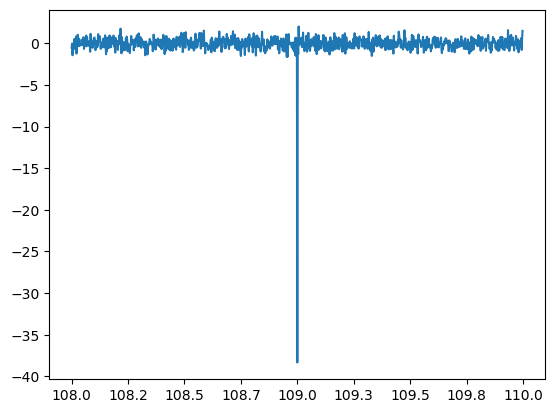

In [30]:
plot((180/pi)*(mean.(eachcol(storeAngle))));
xticks((0:div(buffsz,numticks):buffsz),string.(round.((minF:(maxF-minF)/numticks:maxF),digits=1)));

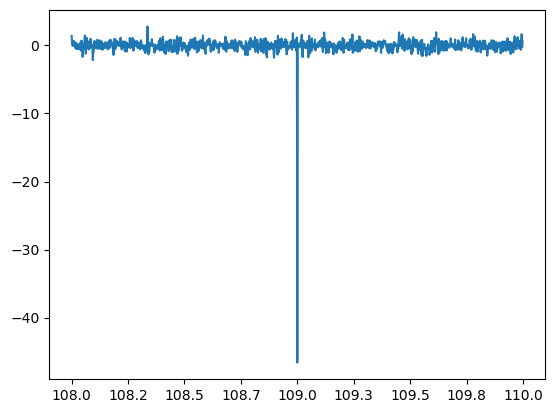

In [31]:
plot((180/pi)*(mean.(eachcol(storeAngle2))));
xticks((0:div(buffsz,numticks):buffsz),string.(round.((minF:(maxF-minF)/numticks:maxF),digits=1)));

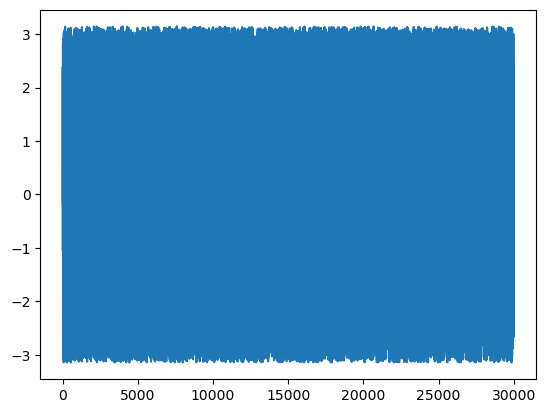

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6e6042b460>

In [32]:
plot(storeAngle[:,713])

# Phase difference

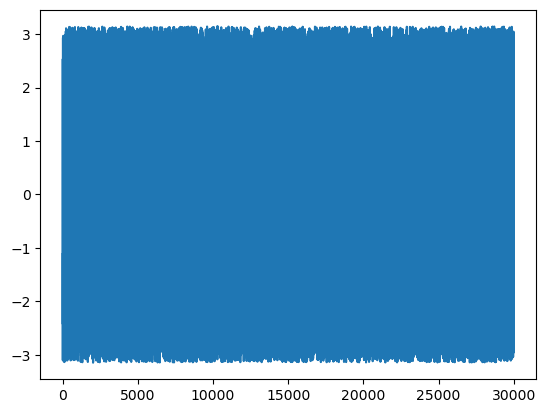

In [33]:
a = (storeAngle[:,763]);
plot(a);

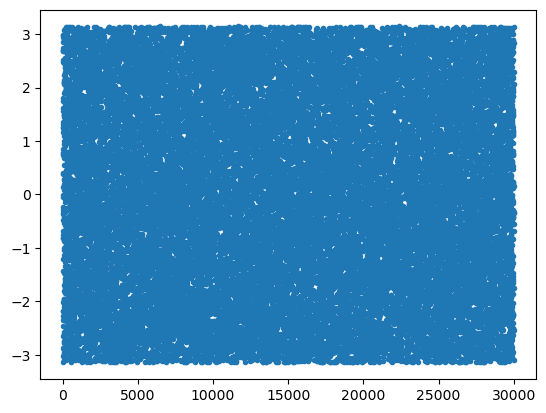

In [34]:
a2 = (storeAngle2[:,763]);
plot(a2,".");

In [35]:
hist(adifs,50);

LoadError: UndefVarError: adifs not defined

In [36]:
legend[763]

109.5

In [37]:
size(storeFftComplex)

(30000, 1024)

In [38]:
midpoint=Int(round((buffsz/2)))

512

    FFTProduct = storeFftComplex2.*conj(storeFftComplex);
@show value,index = findmax(abs.(FFTProduct[4,:][midpoint+10:buffsz]))
@show index=index+midpoint+10-1
plot(angle.(FFTProduct[:,index]),",")

plot(abs.(FFTProduct[:,index]),",")

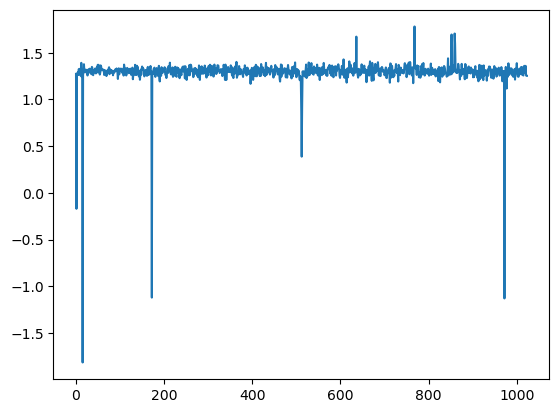

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6e601e7b20>

In [39]:
tempfft = im*zeros(buffsz)
for i=1:30000 
    tempfft.+=storeFftComplex2[i,:].*conj(storeFftComplex[i,:]) 
end

tempfft=tempfft./30000;
plot(angle.(tempfft))

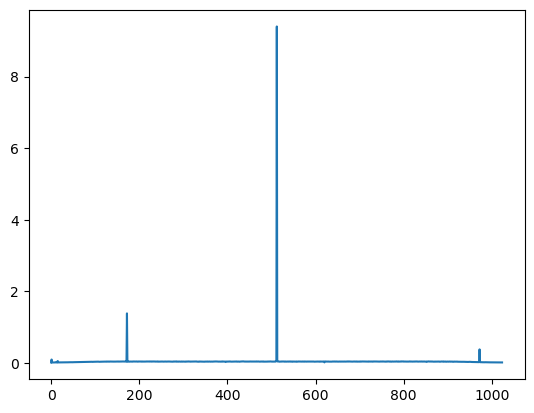

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6e58ddaf50>

In [40]:
plot(abs.(tempfft))

In [41]:
angle.(tempfft)*180/pi

1024-element Vector{Float64}:
 72.99798998932988
 -9.787980962710483
 72.72537251317058
 72.21494606267237
 74.0203914559207
 72.36522775339142
 75.8274969104075
 76.01891314007716
 76.06886052554897
 74.24112498287808
 72.04840008350239
 75.17548208787775
 79.78624508531398
  ⋮
 77.10916641923916
 73.91376218180505
 72.21322573602804
 72.01760349409483
 74.83413885930847
 77.94976572767678
 73.84390255198251
 73.78651392163383
 77.92458163195884
 72.10227012879224
 71.79462484143765
 71.80128438067048

# FM demodulation

In [ ]:
(data, fs) =  fmDemod(storeIq, sampRate)
plotTime(data, fs);

In [ ]:
(data2, fs) =  fmDemod(storeIq2, sampRate)
plotTime(data2, fs);

# Play FM signal

In [ ]:

wavwrite(data, "fmtest.wav", Fs=fs)

In [ ]:
wavplay(data, fs)

In [ ]:
angle(35+54im)